# INTRODUCTION
## Objective:
<span style="font-size:20px; color:black">
    
This notebook will guide you through drug target discovery using **proteome-wide Mendelian randomization**. We'll investigate the potential causal effect of plasma proteins on the risk of ischemic stroke.
</span>

## Learning goals:
<span style="font-size:20px; color:black">
    
 1. Understand the principles of Two-Sample MR.
 2. Format summary statistics for exposures and outcomes from public databases.
 3. Perform the MR analysis using cis-pQTLs on proteins.
 4. Conduct sensitivity analyses by colocalization.
 5. Visualize and interpret the findings of an MR study.
</span>

## Drug-target Discovery
<span style="font-size:20px; color:black">
    
- Traditional Mendelian Randomization is a powerful epidemiological method that uses genetic variants as **instrumental variables (IVs)** to infer the causal relationship between an exposure (e.g., a protein) and an outcome (e.g., a disease).
- Plasma proteins play key roles in a range of biological processes and represent a major source of druggable targets.
- Genetic variants can therefore be used as proxies for studying the effect of pharmacologically perturbing these protein drug targets
- MR serves as a key methodological tool for investigating the repurposing of approved drug targets and discovering novel potential targets.
</span>

## The three core assumptions of MR:
<span style="font-size:20px; color:black">
    
 1. **Relevance:** The genetic variants are strongly associated with the exposure.
 2. **Independence:** The genetic variants are not associated with any confounding factors.
 3. **Exclusion Restriction:** The genetic variants only affect the outcome through the exposure.
</span>

## Citation: 
<span style="font-size:20px; color:black">

Exposure: Plasma Proteomics Data<br>
Sun, B.B., Chiou, J., Traylor, M. et al. Plasma proteomic associations with genetics and health in the UK Biobank. Nature 622, 329–338 (2023). https://doi.org/10.1038/s41586-023-06592-6<br>

Outcome: Gigastroke - Any stroke; Any ischaemic stroke; LAS; CES; SVS<br>
Mishra, A., Malik, R., Hachiya, T. et al. Stroke genetics informs drug discovery and risk prediction across ancestries. Nature 611, 115–123 (2022). https://doi.org/10.1038/s41586-022-05165-3
</span>

# Exercise A. Summary Data Proteome-wide Mendelian randomization
## Preparation 
<span style="font-size:20px; color:black">

- First, list the content of our common folder. You do this in Bash by running the commands below. Click the box and run the commmand (Crtl-Enter on windows/linuz, Cmd-Enter on Mac).
- First run migt give you an error; just ignore that and rerun:
- The folder contains two subfolder called Exposure and Outcome, containing the all gwas summary data files you will use in this exercise.
</span>

In [1]:
# this is a comment. Comments starts with a # and the text is not run as code.

# command to view all the files and folders in your home
ls /home/student/Proteomics_MR/Data

Exposure  Outcome  UKB_IS



## Part 1: Load R Packages
<span style="font-size:20px; color:black">
There may be some warnings, but these warnings will not affect the results. Therefore, we use suppressMessages to suppress the output. Similarly, some commands may produce lengthy output, which will also be suppressed using suppressMessages. <br>
    <br>
Action: Run the code cell below to load the packages.
</span>

In [2]:
suppressMessages(library(TwoSampleMR))
suppressMessages(library(tidyverse))
suppressMessages(library(data.table))
suppressMessages(library(coloc))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
source("/home/student/Proteomics_MR/utils.plot.R")

## Part 2: Load exposure data
<span style="font-size:20px; color:black">
The exposures are plasma proteins, with data obtained from the UK Biobank Pharma Proteomics Project (UKB-PPP).
The dataset includes GWAS summary statistics for 2,314 proteins, derived from approximately 50,000 individuals. <br>
<br>
    
**Instrument Selection** <br>
- pQTLs associated with these proteins (p < 5×10⁻⁸) are included as instrumental variables.
- To minimize potential pleiotropic effects, we have removed cis-pQTLs associated with multiple proteins. Specifically, we retained only genetic instruments that were significantly associated with fewer than five proteins, resulting in the removal of 223 cis-pQTLs linked to more than five proteins. This filtering step is complete and requires no further action.
</span>

In [3]:
head /home/student/Proteomics_MR/Data/Exposure/Exposure_Eur_formatted_t12.txt|column -t

Assay_Target  CHROM  GENPOS_hg38  SNP          Region_ID  Region_Start  Region_End  cis_gene  effect_allele  other_allele  eaf     beta    se     pval      neg_log10_pval  cis_or_trans  N
A1BG          2      27508073     rs1260326    975        26263266      29121418    -         C              T             0.6084  -0.137  0.007  6.31e-80  79.2            trans         33995
A1BG          7      73597712     rs35332062   1247       72399105      74643687    -         A              G             0.1265  -0.125  0.011  3.16e-32  31.5            trans         33995
A1BG          12     103606692    rs2723889    590        102606541     104606692   -         C              T             0.6728  0.053   0.007  1.58e-12  11.8            trans         33995
AAMDC         11     77872220     rs2186564    867        75722702      80160753    AAMDC     A              G             0.1062  -1.064  0.012  1e-307    1620.5          cis           33042
AARSD1        12     54332691     rs11170874

In [4]:
exposure_filepath <- "/home/student/Proteomics_MR/Data/Exposure/Exposure_Eur_formatted_t12.txt"
exposure_dat <- fread(exposure_filepath, nThread = 1) %>% as.data.frame()

# print the number of total proteins
print(length(unique(exposure_dat$Assay_Target)))
# head prints the 6 proteins
print(head(unique(exposure_dat$Assay_Target)))


[1] 2314
[1] "A1BG"    "AAMDC"   "AARSD1"  "ABHD14B" "ABO"     "ACAA1"  


## Part 3: Load outcome data
<span style="font-size:20px; color:black">  

- The outcome is stroke. We will use summary statistics from the GIGASTROKE consortium, which is the largest GWAS meta-analysis of stroke to date.<br>
- For this example, we'll focus on Any Ischemic Stroke (AIS). The ID for this GIGASTROKE study in the database is ebi-a-GCST90027038.<br>

</span>

In [5]:
gunzip -c /home/student/Proteomics_MR/Data/Outcome/GCST90104540.h.tsv.gz|head |column -t

chromosome  base_pair_location  effect_allele  other_allele  beta     standard_error  effect_allele_frequency  p_value   variant_id  ci_upper            ci_lower            hm_coordinate_conversion  odds_ratio          hm_code  rsid
1           794299              G              C             0.035    0.0135          0.8117                   0.009632  NA          1.0633879601596712  1.0085765698279825  lo                        1.0356197087996237  6        rs4951859
1           794707              C              T             -0.0172  0.0225          0.06489999999999996      0.4444    NA          1.0272650711198805  0.9405410351368857  lo                        0.9829470755595441  11       rs148120343
1           798969              C              T             -0.0348  0.0136          0.1634                   0.01077   NA          0.9918890725262217  0.9403943221793144  lo                        0.9657985566542109  11       rs141242758
1           800909              A              T 

In [6]:
# Outcome: Gigastroke Any Ischamic Stroke
outcome_filepath <- "/home/student/Proteomics_MR/Data/Outcome/GCST90104540.h.tsv.gz"
outcome_dat <- fread(outcome_filepath, nThread = 1) %>% as.data.frame() %>% mutate(n_cases = 62100, n_controls = 1234808, pheno = "Any Ischamic Stroke")
str(outcome_dat)

'data.frame':	7465328 obs. of  18 variables:
 $ chromosome              : int  1 1 1 1 1 1 1 1 1 1 ...
 $ base_pair_location      : int  794299 794707 798969 800909 817186 817341 818161 818802 818812 818954 ...
 $ effect_allele           : chr  "G" "C" "C" "A" ...
 $ other_allele            : chr  "C" "T" "T" "T" ...
 $ beta                    : num  0.035 -0.0172 -0.0348 -0.0332 0.0317 0.0289 -0.0253 0.0273 0.0271 0.0249 ...
 $ standard_error          : num  0.0135 0.0225 0.0136 0.0141 0.0124 0.0125 0.0121 0.0123 0.0124 0.0125 ...
 $ effect_allele_frequency : num  0.8117 0.0649 0.1634 0.1716 0.816 ...
 $ p_value                 : num  0.00963 0.4444 0.01077 0.01837 0.01064 ...
 $ variant_id              : logi  NA NA NA NA NA NA ...
 $ ci_upper                : num  1.063 1.027 0.992 0.994 1.058 ...
 $ ci_lower                : num  1.009 0.941 0.94 0.941 1.007 ...
 $ hm_coordinate_conversion: chr  "lo" "lo" "lo" "lo" ...
 $ odds_ratio              : num  1.036 0.983 0.966 0.967 1.032

# Part 4: Format Data for the TwoSampleMR Package

In [7]:
outcome_format <- format_data(dat = outcome_dat,
                              type = "outcome",
                              phenotype_col = "pheno",
                              header = T,
                              snp_col = "rsid",
                              beta_col = "beta",
                              se_col = "standard_error",
                              effect_allele_col = "effect_allele",
                              other_allele_col = "other_allele",
                              pval_col = "p_value",
                              eaf_col = "effect_allele_frequency",
                              ncase_col = "n_cases",
                              ncontrol_col = "n_controls")

str(outcome_format)


Generating sample size from ncase and ncontrol



'data.frame':	7465328 obs. of  14 variables:
 $ effect_allele.outcome: chr  "G" "C" "C" "A" ...
 $ other_allele.outcome : chr  "C" "T" "T" "T" ...
 $ beta.outcome         : num  0.035 -0.0172 -0.0348 -0.0332 0.0317 0.0289 -0.0253 0.0273 0.0271 0.0249 ...
 $ se.outcome           : num  0.0135 0.0225 0.0136 0.0141 0.0124 0.0125 0.0121 0.0123 0.0124 0.0125 ...
 $ eaf.outcome          : num  0.8117 0.0649 0.1634 0.1716 0.816 ...
 $ pval.outcome         : num  0.00963 0.4444 0.01077 0.01837 0.01064 ...
 $ SNP                  : chr  "rs4951859" "rs148120343" "rs141242758" "rs79010578" ...
 $ ncase.outcome        : num  62100 62100 62100 62100 62100 62100 62100 62100 62100 62100 ...
 $ ncontrol.outcome     : num  1234808 1234808 1234808 1234808 1234808 ...
 $ outcome              : chr  "Any Ischamic Stroke" "Any Ischamic Stroke" "Any Ischamic Stroke" "Any Ischamic Stroke" ...
 $ mr_keep.outcome      : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ pval_origin.outcome  : chr  "reported" "reporte

<span style="font-size:20px; color:black">

We prepar two versions of the exposure data: one that includes both cis and trans pQTLs, and another that contains only cis pQTLs. This enables a comparison between standard Mendelian Randomization (MR) and cis-pQTL MR, the latter being more directly applicable to drug target discovery.
</span>

In [8]:
# cis data
exposure_cis <- exposure_dat %>% 
    filter(cis_or_trans == "cis")

## TwoSampleMR package format
# cis + trans pQTLs as IVs
exposure_dat_format <- format_data(dat = exposure_dat, 
                                   type = "exposure",
                                   phenotype_col = "Assay_Target",
                                   header = T,
                                   snp_col = "SNP",
                                   beta_col = "beta",
                                   se_col = "se",
                                   effect_allele_col = "effect_allele",
                                   other_allele_col = "other_allele",
                                   eaf_col = "eaf",
                                   pval_col = "pval",
                                   samplesize_col = "N")
# cis pQTLs as IVs
exposure_cis_format <- format_data(dat = exposure_cis, 
                                   type = "exposure",
                                   phenotype_col = "Assay_Target",
                                   header = T,
                                   snp_col = "SNP",
                                   beta_col = "beta",
                                   se_col = "se",
                                   effect_allele_col = "effect_allele",
                                   other_allele_col = "other_allele",
                                   eaf_col = "eaf",
                                   pval_col = "pval",
                                   samplesize_col = "N")

str(exposure_cis_format)

'data.frame':	1662 obs. of  12 variables:
 $ SNP                   : chr  "rs2186564" "rs323500" "rs373373105" "rs156265" ...
 $ effect_allele.exposure: chr  "A" "T" "CG" "G" ...
 $ other_allele.exposure : chr  "G" "C" "C" "C" ...
 $ eaf.exposure          : num  0.106 0.29 0.012 0.144 0.308 ...
 $ beta.exposure         : num  -1.064 0.132 -1.45 -0.125 0.142 ...
 $ se.exposure           : num  0.012 0.008 0.036 0.011 0.008 0.014 0.009 0.008 0.006 0.007 ...
 $ pval.exposure         : num  1.00e-200 2.51e-61 1.00e-200 5.01e-31 6.31e-66 ...
 $ samplesize.exposure   : int  33042 33533 33375 32907 33335 33942 33424 33985 33043 33187 ...
 $ exposure              : chr  "AAMDC" "AARSD1" "ABHD14B" "ACAA1" ...
 $ mr_keep.exposure      : logi  TRUE TRUE TRUE TRUE TRUE TRUE ...
 $ pval_origin.exposure  : chr  "reported" "reported" "reported" "reported" ...
 $ id.exposure           : chr  "rnGkVO" "H9Dlne" "DZXQ2B" "wElRBy" ...


## Part 5: Instrument strength

**R² (Proportion of Variance Explained) and F-statistics:**

To evaluate the strength of the genetic instruments used in Mendelian Randomization (MR) analyses, we calculated the proportion of variance in the exposure explained by each SNP (denoted as R² or PVE), as well as the corresponding F-statistics.

**1. Formula for R² (PVE)**

The proportion of phenotypic variance explained by a SNP is calculated using the following formula:

$$
R^2 = \frac{2 \cdot \beta^2 \cdot \text{EAF} \cdot (1 - \text{EAF})}{2 \cdot \beta^2 \cdot \text{EAF} \cdot (1 - \text{EAF}) + 2 \cdot \text{SE}^2 \cdot n \cdot \text{EAF} \cdot (1 - \text{EAF})}
$$

Where:

- $\beta$ = effect size of SNP on the exposure  
- $EAF$ = effect allele frequency  
- $SE$ = standard error of the SNP-exposure association  
- $n$ = sample size

**2. Formula for F-statistic**

To assess the instrument strength, the F-statistic is calculated from \( R^2 \) as follows:

- General formula (multiple instruments):

$$
F = \frac{R^2 / k}{(1 - R^2) / (n - k - 1)}
$$

- Simplified (single SNP instrument, \( k = 1 \)):

$$
F = \frac{R^2}{1 - R^2} \cdot (n - 2)
$$

Where:

- $R^2$ = variance explained by the instrument  
- $n$ = sample size  
- $k$ = number of instruments (for single SNP, \( k = 1 \))

**3. Interpretation**

- An **F-statistic > 10** is generally considered evidence of a **strong instrument**.
- Lower values may indicate **weak instruments**, which can bias MR estimates.




[1] "Minimum value of F-statistics among all cis-pQTLs:"
[1] 40.64062


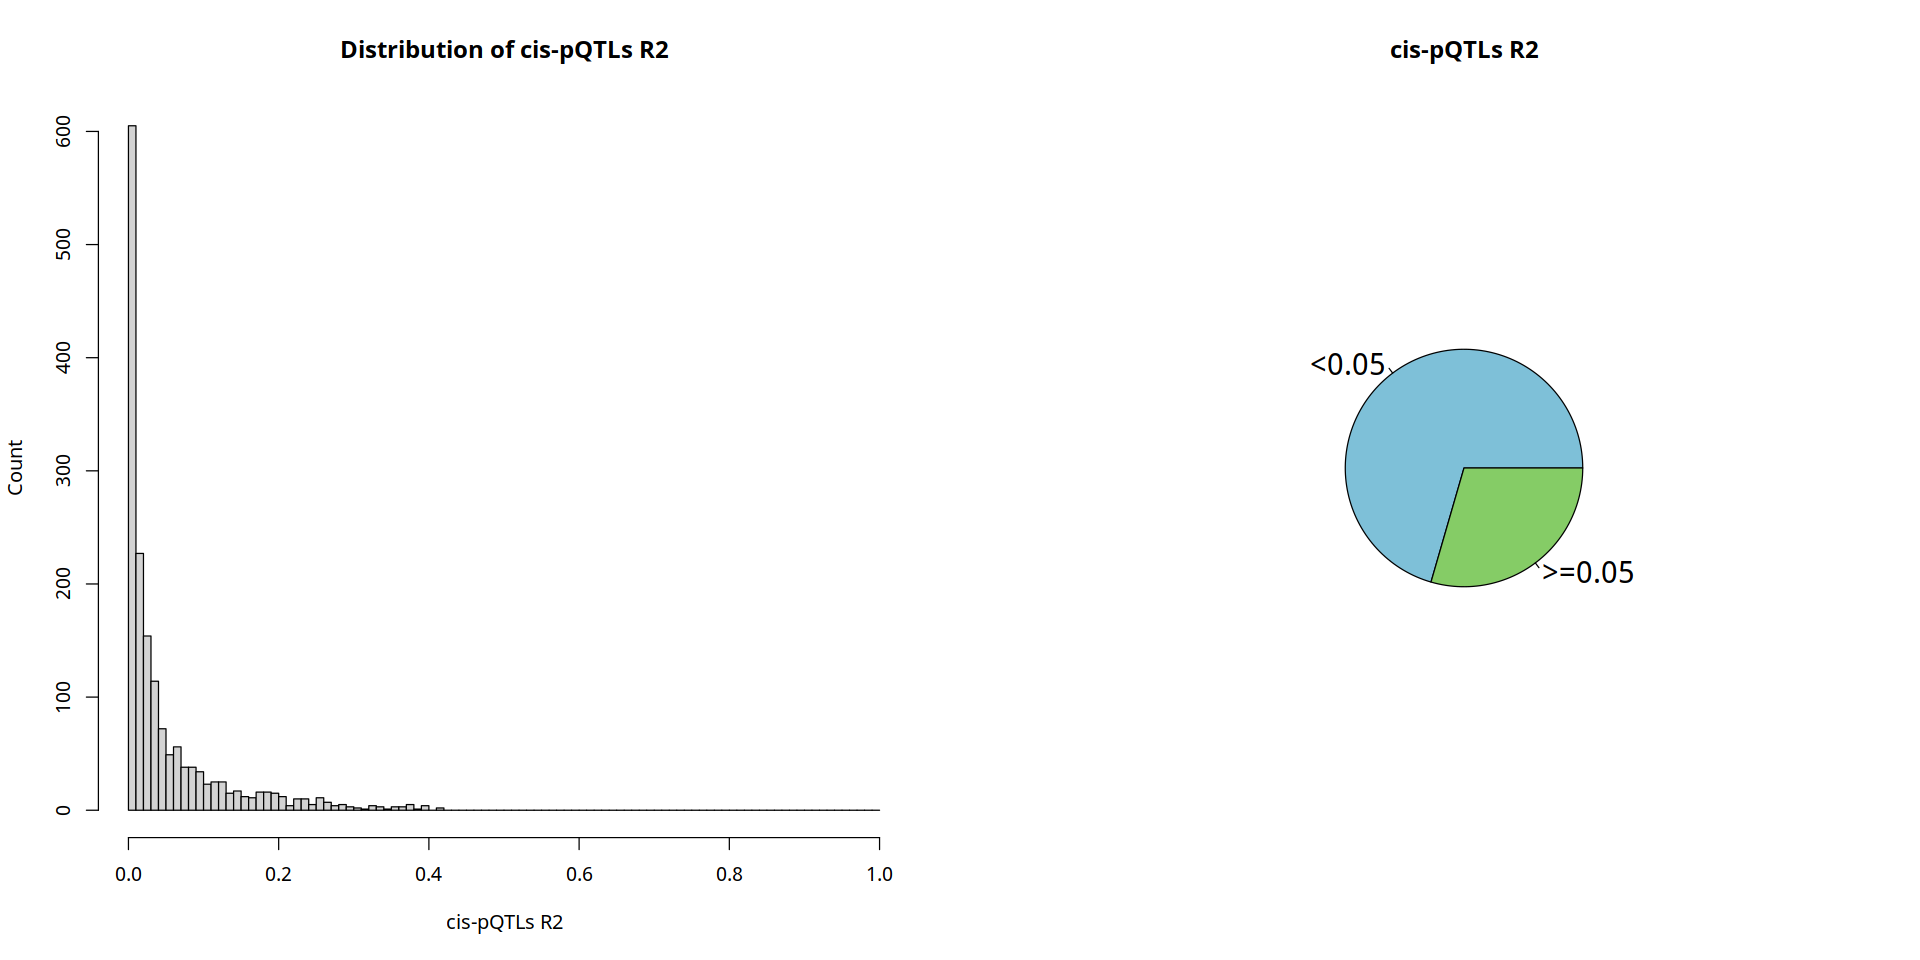

In [9]:
exposure_cis_format <- add_rsq(exposure_cis_format) %>% 
  mutate(F = ((samplesize.exposure - 1 - 1) / 1) * (rsq.exposure / (1 - rsq.exposure)),
         rsq_cate = cut(rsq.exposure, breaks = c(0, 0.05, Inf), labels = c("<0.05", ">=0.05")),
         F_cate = cut(F, breaks = c(0, 10, Inf), labels = c("<10", ">=10")))

options(repr.plot.width = 16, repr.plot.height = 8)
par(mfrow = c(1, 2))

# Histogram of R2
hist(exposure_cis_format$rsq.exposure, breaks = seq(0, 1, 0.01),xlab = "cis-pQTLs R2", ylab = "Count", main = "Distribution of cis-pQTLs R2")
# Pie plot of R2
pie(table(exposure_cis_format$rsq_cate), labels = c("<0.05", ">=0.05"), main = "cis-pQTLs R2", col = c('#7EC0D8','#85CC66'),cex = 1.5)

par(mfrow = c(1, 1))

print("Minimum value of F-statistics among all cis-pQTLs:")
print(min(exposure_cis_format$F))

<span style="font-size:20px; color:black">
    
**Druggability of proteins in Olink panels**<br>    
Proteins are classified into four groups based on <u>Druggable genome</u>: 
- **Tier 1**: proteins that are efficacy targets of approved small molecules and biotherapeutic drugs;
- **Tier 2**: proteins closely related to approved drug targets or with associated drug-like compounds;
- **Tier 3**: secreted or extracellular proteins or proteins distantly related to approved drug targets;
- **Unclassified**: proteins have unknown druggable status.

709/1225 = 58% Olink proteins are efficacy targets or are related to approved drug targets

**Citation**: Chris Finan et al. ,The druggable genome and support for target identification and validation in drug development.Sci. Transl. Med.9,eaag1166(2017).
</span>

'data.frame':	1231 obs. of  14 variables:
 $ Assay.Target       : chr  "AAMDC" "AARSD1" "ACAA1" "ACADM" ...
 $ UKBPPP.ProteinID   : chr  "AAMDC:Q9H7C9:OID30236:v1" "AARSD1:Q9BTE6:OID21311:v1" "ACAA1:P09110:OID21269:v1" "ACADM:P11310:OID31277:v1" ...
 $ Olink.ID           : chr  "OID30236" "OID21311" "OID21269" "OID31277" ...
 $ Protein.panel      : chr  "Cardiometabolic_II" "Oncology" "Oncology" "Oncology_II" ...
 $ Gene.symbol        : chr  "AAMDC" "AARSD1" "ACAA1" "ACADM" ...
 $ UniProt            : chr  "Q9H7C9" "Q9BTE6" "P09110" "P11310" ...
 $ Gene.CHROM         : chr  "11" "17" "3" "1" ...
 $ Gene.start         : chr  "77821109" "42950526" "38103129" "75724431" ...
 $ Gene.end           : chr  "77918432" "42964498" "38137242" "75787575" ...
 $ druggability_tier  : chr  "unclassified" "unclassified" "unclassified" "unclassified" ...
 $ small_mol_druggable: chr  NA NA NA NA ...
 $ bio_druggable      : chr  NA NA NA NA ...
 $ adme_gene          : chr  NA NA NA NA ...
 $ panel2      

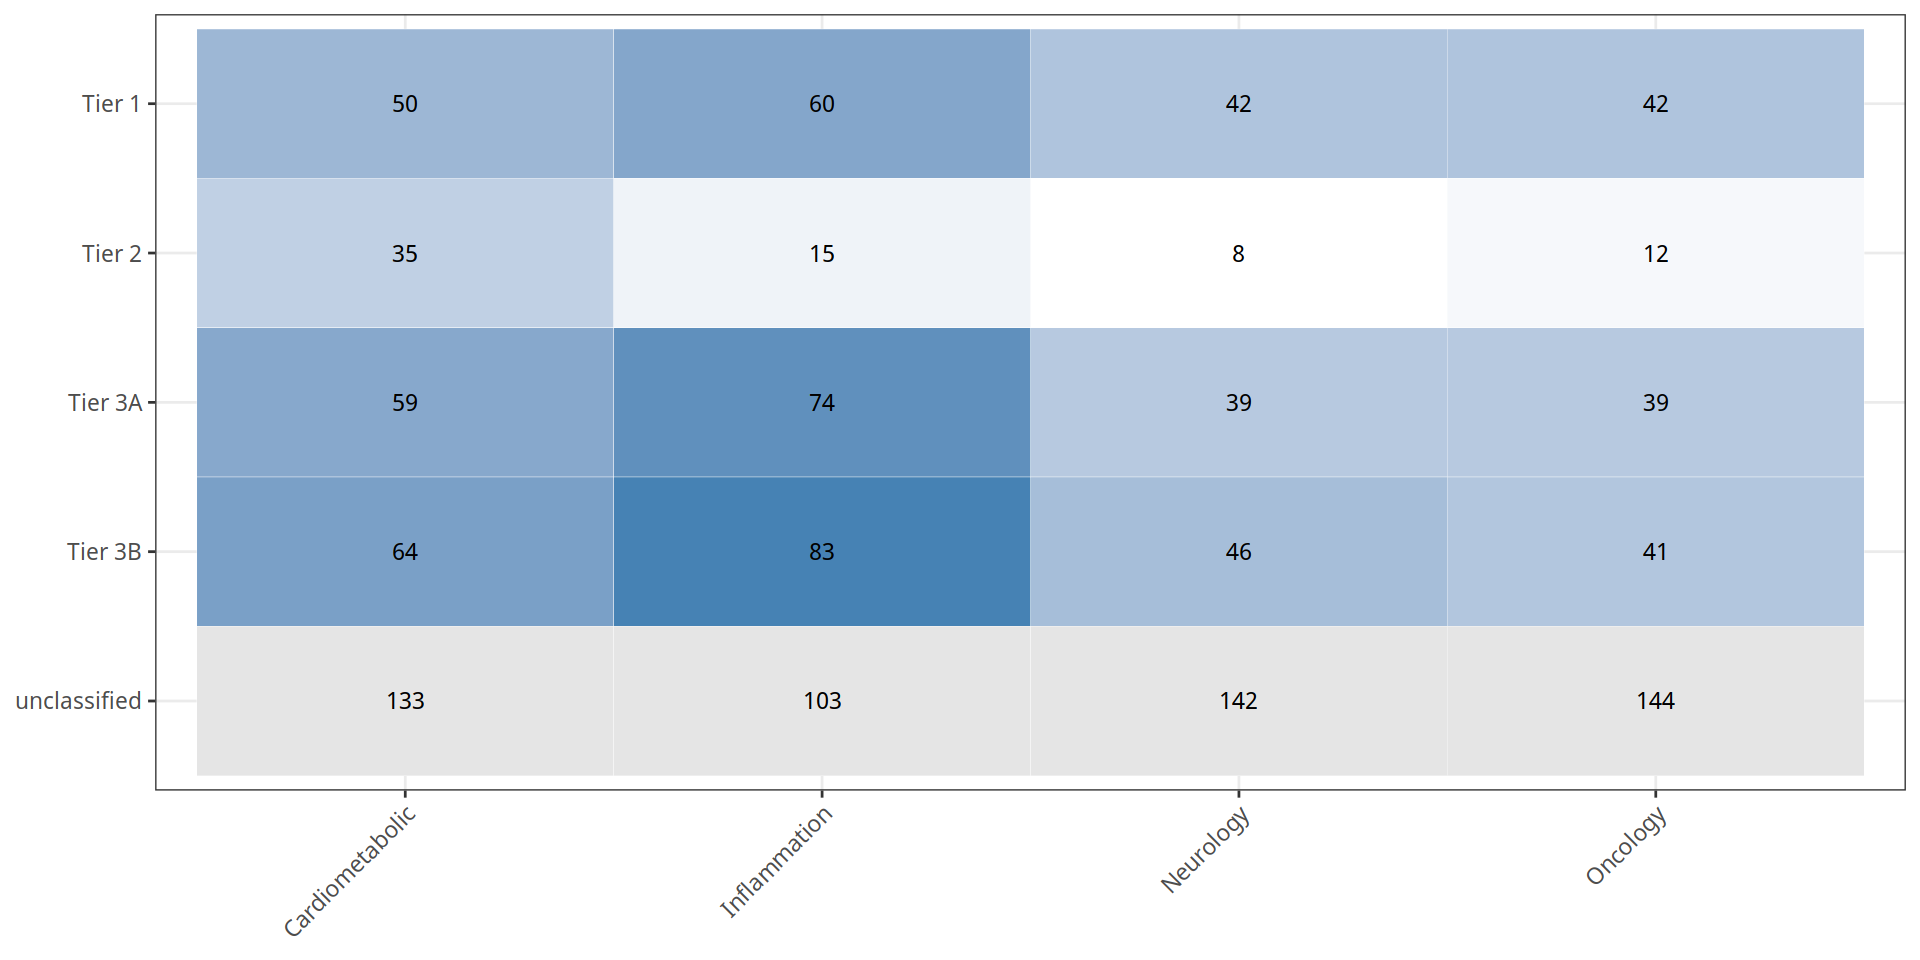

In [10]:
# load proteins information data
pro_info <- read.csv("/home/student/Proteomics_MR/Data/Exposure/Protein_information.csv", header = T, sep = ",")
str(pro_info)

# Heatmap of protein counts across druggability tiers and Olink panels.
data_long <- data.frame(table(pro_info$druggability_tier, pro_info$panel))
plot_heat(data_long)


## Part 6: Performing traditional univariate MR
<span style="font-size:20px; color:black">
    
- Firstly, **harmonizing the data**. This is a critical step. We must ensure that the effect of a SNP on the exposure and its effect on the outcome correspond to the same allele. The harmonise_data() function manages this by checking and flipping alleles where necessary. It will remove any SNPs that are palindromic with ambiguous allele frequencies.
- Now we are ready to estimate the causal effect! The mr() function will run several different MR methods. The main method we will focus on is the **Inverse Variance Weighted (IVW)** method, which combines the estimates from each SNP to get a summary causal effect.
</span>

In [11]:
# 2. Mendelian randomization
# 2.1 Univariate MR

# MR 
# harmonise
dat <- suppressMessages(harmonise_data(exposure_dat = exposure_dat_format[exposure_dat_format$exposure == "FURIN",], outcome_dat = outcome_format))
# Perform the MR analysis
res <- suppressMessages(mr(dat))

print("MR Analysis Results")
print(res)

[1] "MR Analysis Results"
  id.exposure id.outcome             outcome exposure                    method
1      T4lrNN     4b0sLP Any Ischamic Stroke    FURIN                  MR Egger
2      T4lrNN     4b0sLP Any Ischamic Stroke    FURIN           Weighted median
3      T4lrNN     4b0sLP Any Ischamic Stroke    FURIN Inverse variance weighted
4      T4lrNN     4b0sLP Any Ischamic Stroke    FURIN               Simple mode
5      T4lrNN     4b0sLP Any Ischamic Stroke    FURIN             Weighted mode
  nsnp          b         se         pval
1    3  0.4144816 0.10369123 0.1560606406
2    3  0.1522076 0.03958710 0.0001206124
3    3  0.1569771 0.06946112 0.0238257158
4    3 -0.0265309 0.12018616 0.8457748668
5    3  0.2099043 0.04318610 0.0398185691


<span style="font-size:20px; color:black">
    
**Interpreting the Primary Result**<br>
    Look at the IVW row in the results table:

- **b:** This is the causal estimate. It represents the change in the log odds of stroke for a one-unit increase in standardized protein levels.
- **se:** The standard error of the estimate.
- **pval:** The p-value for the causal estimate. A low p-value (e.g., < 0.05) suggests evidence for a significant causal effect.
</span>

<span style="font-size:20px; color:black">

**Heterogeneity and Pleiotropy Tests** <br>
a) Heterogeneity Test (Cochran's Q)<br>
Asks: "Do all instruments for this protein suggest a consistent causal effect?"<br>
A p-value < 0.05 indicates significant heterogeneity, meaning some SNPs might be behaving differently.<br>

b) Pleiotropy Test (MR-Egger Intercept)<br>
Asks: "Is there evidence of directional pleiotropy (a systematic side-effect)?"<br>
An intercept p-value < 0.05 suggests potential pleiotropy, which could bias the main MR result.<br>
</span>

In [12]:
# --- Perform Sensitivity Analyses ---
print("Heterogeneity test:")
mr_heterogeneity(dat)[,3:8]

print("Pleiotropy test:")
mr_pleiotropy_test(dat)[,3:7]


[1] "Heterogeneity test:"


outcome,exposure,method,Q,Q_df,Q_pval
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Any Ischamic Stroke,FURIN,MR Egger,0.3253182,1,0.56842900
Any Ischamic Stroke,FURIN,Inverse variance weighted,7.3502502,2,0.02534623


[1] "Pleiotropy test:"


outcome,exposure,egger_intercept,se,pval
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Any Ischamic Stroke,FURIN,-0.04015733,0.01515109,0.2296794


$T4lrNN.4b0sLP

attr(,"split_type")
[1] "data.frame"
attr(,"split_labels")
  id.exposure id.outcome
1      T4lrNN     4b0sLP

$T4lrNN.4b0sLP

attr(,"split_type")
[1] "data.frame"
attr(,"split_labels")
  id.exposure id.outcome
1      T4lrNN     4b0sLP

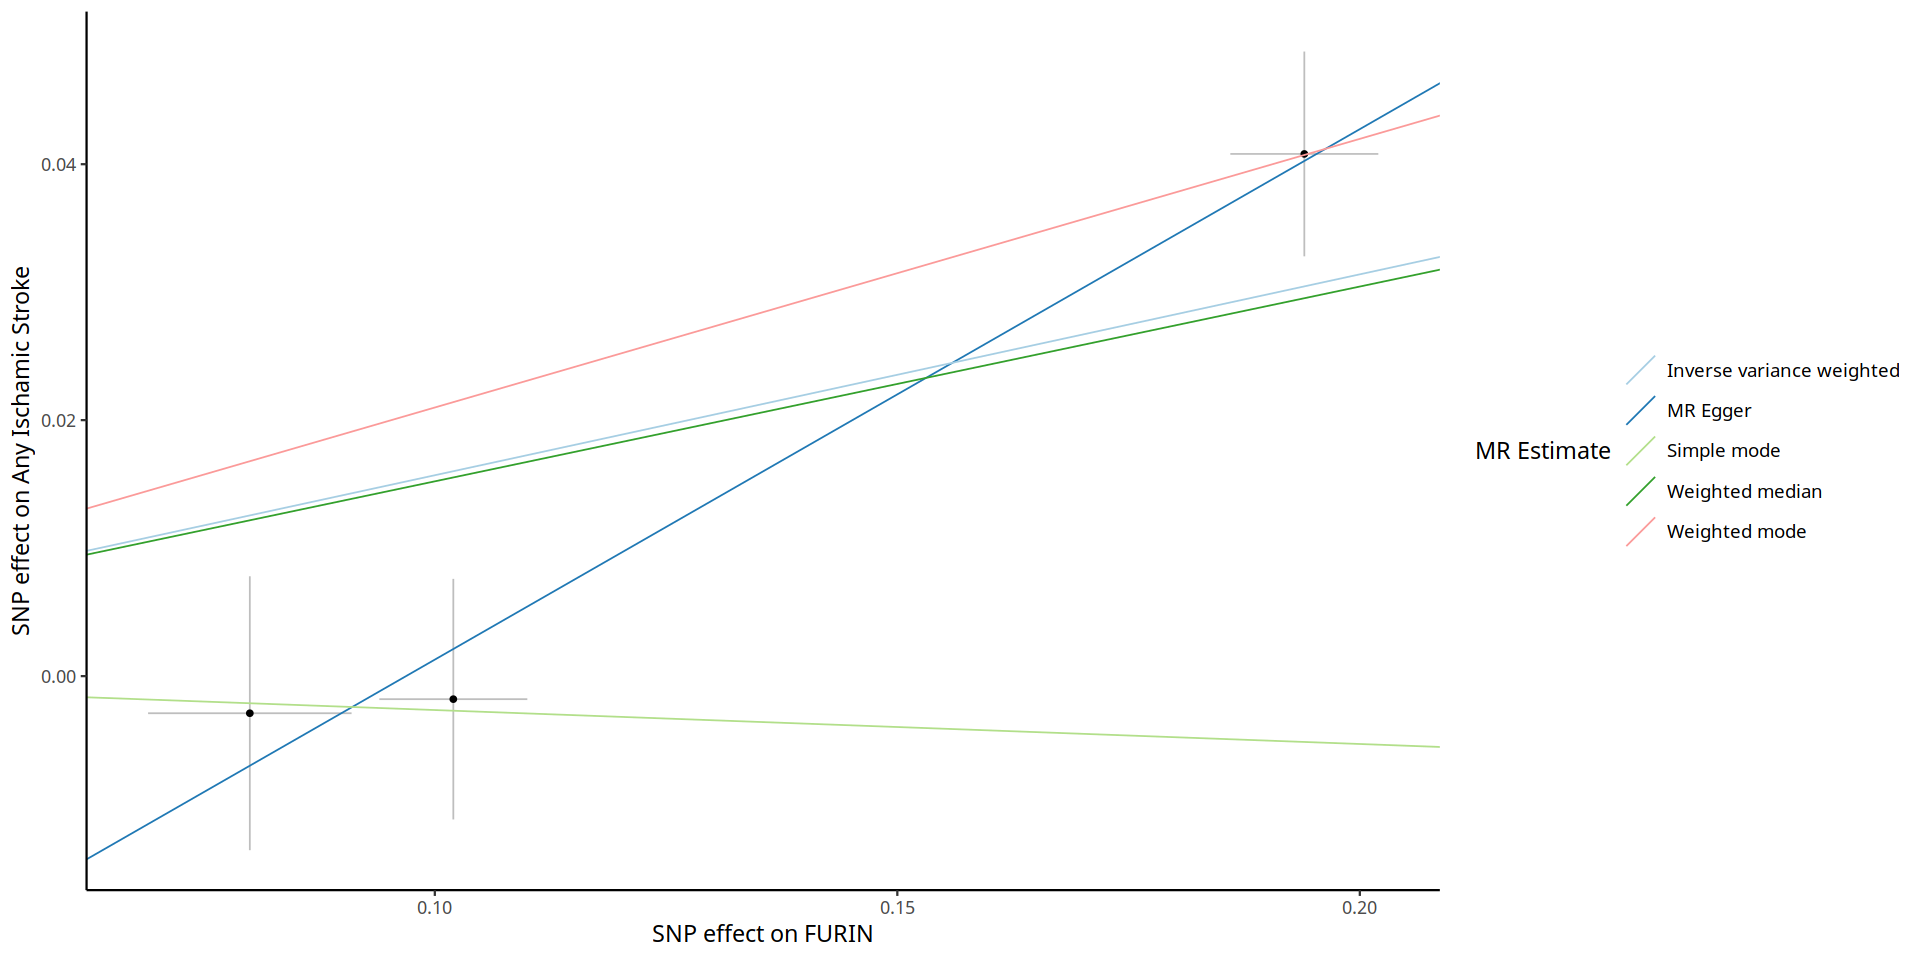

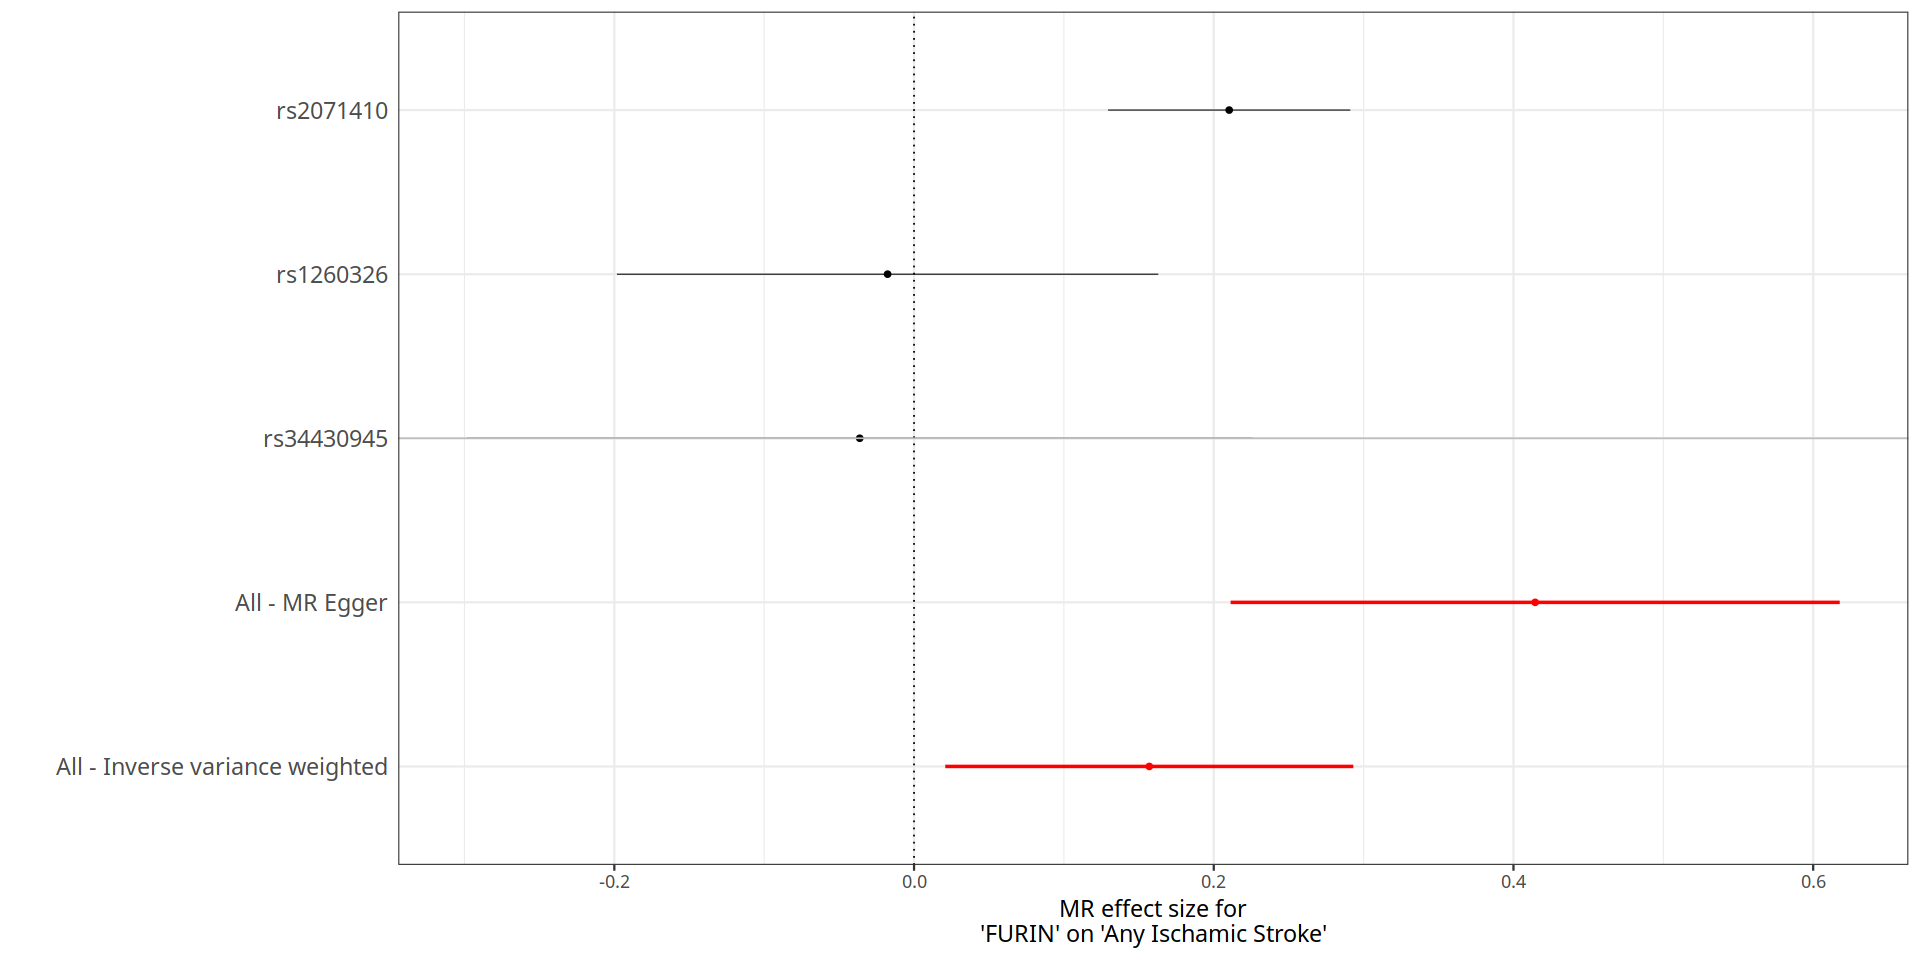

In [13]:
source("/home/student/Proteomics_MR/utils.plot.R")
MR_scatter_plot(res, dat)
MR_forest_plot(mr_singlesnp(dat))

# Part 7: Performing the cis-pQTLs MR
<span style="font-size:20px; color:black">
    
cis-pQTLs are SNPs located near the gene that codes for the protein. They are preferred for MR as their effect is more likely to be specific to the target protein. trans-pQTLs are far away and their mechanism is less clear, so we exclude them for a more robust analysis.

</span>

In [14]:
# Proteomics MR: cis-pQTLs
dat_cis <- suppressMessages(harmonise_data(exposure_dat = exposure_cis_format, outcome_dat = outcome_format))
res_cis <- suppressMessages(mr(dat_cis))

# False Discovery Rate (FDR) to control Type I errors in multiple hypothesis testing.
res_cis$fdr <- p.adjust(res_cis$pval, method = "fdr")
print(res_cis[res_cis$fdr < 0.05,])

     id.exposure id.outcome             outcome exposure     method nsnp
8         0AY7Xt     4b0sLP Any Ischamic Stroke KIAA0319 Wald ratio    1
145       7aKPz5     4b0sLP Any Ischamic Stroke  TMPRSS5 Wald ratio    1
149       7BNrJ5     4b0sLP Any Ischamic Stroke    FURIN Wald ratio    1
575       jiLqhS     4b0sLP Any Ischamic Stroke     GRK5 Wald ratio    1
695       MAdKnI     4b0sLP Any Ischamic Stroke    PROCR Wald ratio    1
834       PUQr3f     4b0sLP Any Ischamic Stroke     FGF5 Wald ratio    1
1149      xzzUtY     4b0sLP Any Ischamic Stroke    MMP12 Wald ratio    1
               b          se         pval          fdr
8    -0.10714286 0.024350649 1.082509e-05 3.315183e-03
145   0.03490446 0.009426752 2.133148e-04 3.733009e-02
149   0.21030928 0.041237113 3.396535e-07 1.386918e-04
575  -0.19115479 0.028009828 8.819435e-12 1.080381e-08
695  -0.08164384 0.019178082 2.070561e-05 5.072873e-03
834   0.04164223 0.011143695 1.863459e-04 3.733009e-02
1149 -0.07049399 0.013351135 1.


<span style="font-size:20px; color:black">

**Steiger Test for Causal Directionality**    
This test checks if the causal direction (protein -> disease) is correct.
</span>

In [15]:
# steiger test
steiger_results <- directionality_test(dat_cis)

print(head(steiger_results))
print("All causal directions (protein -> disease) are correct:")
print(table(steiger_results$correct_causal_direction))

r.exposure and/or r.outcome not present.

Calculating approximate SNP-exposure and/or SNP-outcome correlations, assuming all are quantitative traits. Please pre-calculate r.exposure and/or r.outcome using get_r_from_lor() for any binary traits



  id.exposure id.outcome exposure             outcome snp_r2.exposure
1      00ggf5     4b0sLP SERPING1 Any Ischamic Stroke     0.018597205
2      019kWz     4b0sLP      CFD Any Ischamic Stroke     0.012037833
3      01imWJ     4b0sLP    IL17D Any Ischamic Stroke     0.027243563
4      07NGWu     4b0sLP  GPIHBP1 Any Ischamic Stroke     0.026677291
5      07t5j7     4b0sLP     NBL1 Any Ischamic Stroke     0.005764128
6      0aALhi     4b0sLP    GFRA2 Any Ischamic Stroke     0.026883699
  snp_r2.outcome correct_causal_direction  steiger_pval
1   1.163283e-10                     TRUE 2.139921e-137
2   2.870584e-08                     TRUE  3.813301e-89
3   3.182615e-06                     TRUE 1.571008e-192
4   8.024422e-08                     TRUE 6.939416e-196
5   1.311919e-06                     TRUE  3.893074e-42
6   1.145001e-06                     TRUE 4.324429e-194
[1] "All causal directions (protein -> disease) are correct:"

TRUE 
1256 


<span style="font-size:20px; color:black">

Compared to the results of cis + trans pQTLs MR, the MR analysis using only cis pQTLs yields a more statistically significant result:
</span>

In [16]:
print("Cis+trans MR Analysis Results")
print(res[3,3:9])

print("Only cis MR Analysis Results")
print(res_cis[res_cis$exposure == "FURIN",3:9])

[1] "Cis+trans MR Analysis Results"
              outcome exposure                    method nsnp         b
3 Any Ischamic Stroke    FURIN Inverse variance weighted    3 0.1569771
          se       pval
3 0.06946112 0.02382572
[1] "Only cis MR Analysis Results"
                outcome exposure     method nsnp         b         se
149 Any Ischamic Stroke    FURIN Wald ratio    1 0.2103093 0.04123711
            pval
149 3.396535e-07


# Part 8: Visualizing Results with a Forest Plot
<span style="font-size:20px; color:black">
A forest plot is the best way to visualize and compare the causal effects of significant proteins
</span>


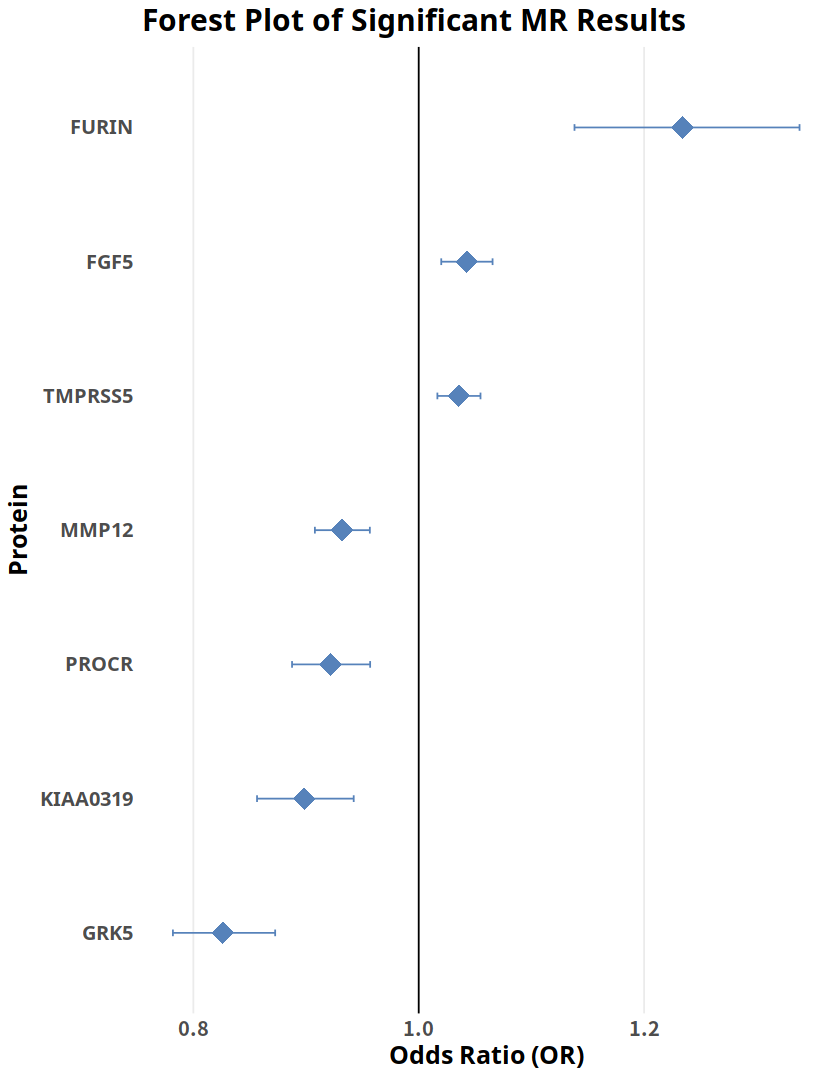

In [17]:
options(repr.plot.width = 7, repr.plot.height = 9)
p_forest <- forest_plot(res_cis)
p_forest

# Exercise B. Colocalization Analysis 
<span style="font-size:20px; color:black">
    
In cis-pQTL MR studies, colocalization analysis plays a critical role in investigating whether the genetic associations with both protein and outcome shared the same causal variant. <br>

5 hypothesises in colocalization: <br>

H0: No association with either trait <br>
H1: Association with trait 1, not with trait 2 <br>
H2: Association with trait 2, not with trait 1 <br>
H3: Association with trait 1 and trait 2, two independent SNPs <br>
H4: Association with trait 1 and trait 2, one shared SNP <br>

In this exercise, trait 1 is protein and trait 2 is ischaemic stroke
</span>


## Part 1. Calculating the posterior probability for each hypothesis

In [18]:
# --- Colocalization Analysis for FURIN and Ischaemic Stroke ---
# load summary data for Proteins
FURIN_coloc <- fread("/home/student/Proteomics_MR/Data/Exposure/coloc/UKB_PROTEIN_CIS_region_FURIN.txt", nThread = 4) %>% 
  mutate(across(c(pvalues, N, MAF, beta, varbeta), ~ as.numeric(as.character(.)))) %>% 
  distinct(snp, .keep_all = TRUE)

# Format for coloc: requires beta, varbeta (se^2), and sample size (N).
D1 <- list(
  pvalues = FURIN_coloc$pvalues,
  MAF = FURIN_coloc$MAF,
  beta = FURIN_coloc$beta,
  varbeta = FURIN_coloc$varbeta,
  snp = FURIN_coloc$snp,
  N = FURIN_coloc$N,
  type = "quant" # "quant" for quantitative trait
)

# --- 2. Prepare Outcome Data for Coloc ---
D2 <- list(
  beta = outcome_format$beta.outcome,
  varbeta = outcome_format$se.outcome^2,
  pvalues = outcome_format$pval.outcome,
  snp = outcome_format$SNP,
  N = outcome_format$samplesize.outcome,
  s = (outcome_format$ncase.outcome / outcome_format$samplesize.outcome)[1], # Proportion of cases
  type = "cc" # "cc" for case-control
)

# --- 3. Run Colocalization ---
coloc_results <- suppressWarnings(coloc.abf(dataset1 = D1, dataset2 = D2))

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
1.61e-131  5.93e-04 4.09e-132  1.49e-04  9.99e-01 
[1] "PP abf for shared variant: 99.9%"


## Part 2. Interpreting and Visualizing the Colocalization Result 
<span style="font-size:20px; color:black">

- **PP.H4.abf > 0.8** suggests the protein and disease share a causal genetic signal

</span>



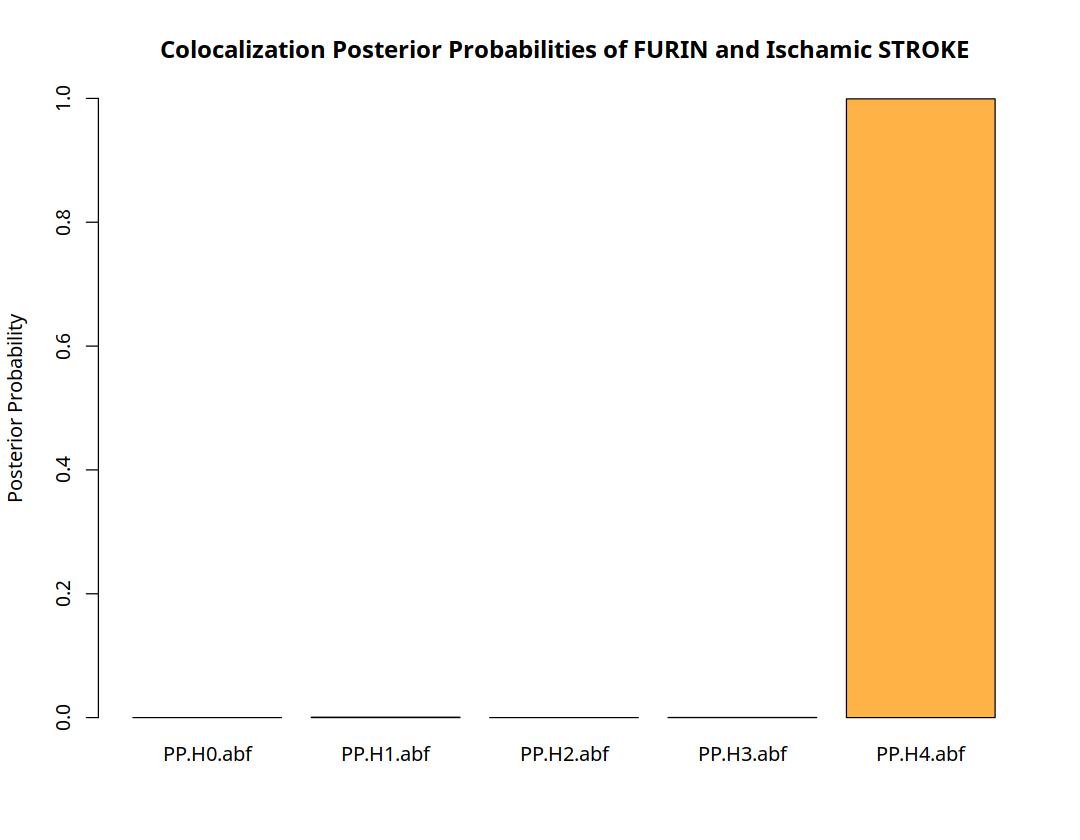

In [19]:
plot_pph <- coloc_results$summary[c("PP.H0.abf", "PP.H1.abf", "PP.H2.abf", "PP.H3.abf", "PP.H4.abf")]
options(repr.plot.width = 9, repr.plot.height = 7)
barplot(plot_pph,
        names.arg = names(plot_pph),
        col = c("#F8766D", "#7CAE00", "#00BFC4", "#C77CFF", "#FFB347"),
        ylab = "Posterior Probability",ylim = c(0,1),
        main = "Colocalization Posterior Probabilities of FURIN and Ischamic STROKE")

## Part 3. For all proteins with FDR < 0.05, we performed sensitivity analysis using colocalization：

In [20]:
# 1. list of target proteins (fdr < 0.05 in proteomics MR)
target_proteins <- c("FURIN", "MMP12", "KIAA0319", "PROCR", "GRK5", "FGF5","TMPRSS5")

# 2. Run the function to get the results table
coloc_results_table <- run_protein_coloc(protein_list = target_proteins,outcome_df = outcome_format)

# 3. View the final output table
print(coloc_results_table)

Processing: FURIN



PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
1.61e-131  5.93e-04 4.09e-132  1.49e-04  9.99e-01 
[1] "PP abf for shared variant: 99.9%"


Processing: MMP12



PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.00e+00  1.91e-05  0.00e+00  6.43e-05  1.00e+00 
[1] "PP abf for shared variant: 100%"


Processing: KIAA0319



PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.00e+00  6.49e-03  0.00e+00  2.49e-05  9.93e-01 
[1] "PP abf for shared variant: 99.3%"


Processing: PROCR



PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.00e+00  6.64e-07  0.00e+00  5.02e-05  1.00e+00 
[1] "PP abf for shared variant: 100%"


Processing: GRK5



PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.00e+00  6.49e-03  0.00e+00  2.49e-05  9.93e-01 
[1] "PP abf for shared variant: 99.3%"


Processing: FGF5



PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.000000  0.096900  0.000000  0.000402  0.903000 
[1] "PP abf for shared variant: 90.3%"


Processing: TMPRSS5



PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.00e+00  1.18e-01  0.00e+00  8.07e-05  8.82e-01 
[1] "PP abf for shared variant: 88.2%"
# A tibble: 7 × 7
  protein  nsnps PP.H0.abf   PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf
  <chr>    <dbl>     <dbl>       <dbl>     <dbl>     <dbl>     <dbl>
1 FURIN     6294 1.61e-131 0.000593    4.09e-132 0.000149      0.999
2 MMP12    11212 0         0.0000191   0         0.0000643     1.00 
3 KIAA0319 11029 0         0.00649     0         0.0000249     0.993
4 PROCR    10525 0         0.000000664 0         0.0000502     1.00 
5 GRK5     11029 0         0.00649     0         0.0000249     0.993
6 FGF5      9425 0         0.0969      0         0.000402      0.903
7 TMPRSS5   9030 0         0.118       0         0.0000807     0.882


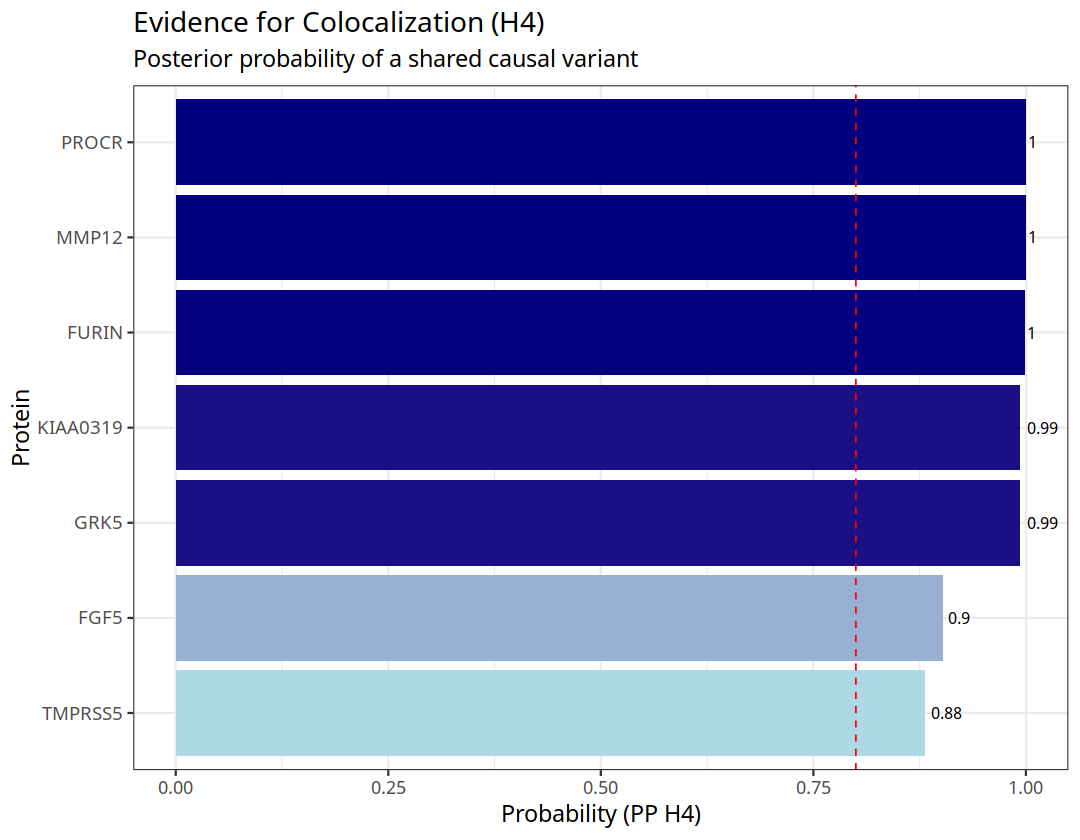

In [21]:
# --- Create the plot ---
barplot_coloc(coloc_results_table)

## Part 4: Visualizing Colocalization Results with Locuszoom

In [22]:
# too slow
#/home/student/miniconda3/envs/ldsc_env/bin/python /home/tch_wyd/locuszoom/bin/locuszoom --build hg38 \
#    --metal /home/student/Proteomics_MR/Data/Outcome/GCST90104540.h.tsv.gz \
#    --delim ' ' \
#    --pvalcol p_value \
#    --markercol SNP \
#    --refsnp rs2071410 \
#    --flank 250kb \
#    --prefix /home/tch_fz/GCST90104540_FURIN_rs2071410 \
#    --pop EUR \
#    --build hg38 \
#    --source 1000G_Nov2014 \
#    --cache None \
#    --ignore-vcf-filter signifLine="7.3" signifLineColor="grey" signifLineType="2" signifLine="7.3" signifLineColor="grey" signifLineType="2" signifLineWidth="2" axisSize=1.2 axisTextSize=1.2 axisTextColor="black" refsnpShadow=TRUE refsnpTextSize=1.2 refsnpLineColor="transparent" refDot=1.2 geneFontSize=1 legend="right" showRecomb=TRUE condRefsnpPch=23

In [23]:
suppressMessages(library(ggplot2))
suppressMessages(library(tidyverse))
suppressMessages(library(cowplot))
suppressMessages(library(ggpubr))
suppressMessages(library(plotgardener))#  a specialized package for arranging complex genomic plots (like LocusZoom plots, gene tracks, etc.) into publication-quality figures.
suppressMessages(library("TxDb.Hsapiens.UCSC.hg38.knownGene")) #This contains a database of gene and transcript locations for the human genome (build hg38), based on annotations from the UCSC Genome Browser.
suppressMessages(library(org.Hs.eg.db))

#' @param file_path Specifies the path to the data file for the locuszoom Rdata .
#' @param refSNP Defines the reference SNP rs2071410 to be highlighted on the plot.
#' @param refSNP_POS Specifies the genomic coordinate of the reference SNP .
#' @param pheno Sets the title or label for this specific plot to "FURIN".

plot1 <- plot_locuszoom(file_path = "/home/student/Proteomics_MR/Data/Exposure/coloc/FURIN/chr15_90627710-91127710.Rdata", refSNP = "rs2071410", refSNP_POS = "90877710", pheno = "FURIN")
plot2 <- plot_locuszoom(file_path = "/home/student/Proteomics_MR/Data/Exposure/coloc/GCST90104540_hg38_FURIN_rs2071410__250719_rs2071410/chr15_90627710-91127710.Rdata", refSNP = "rs2071410", refSNP_POS = "90877710", pheno = "Ischaemic Stroke")

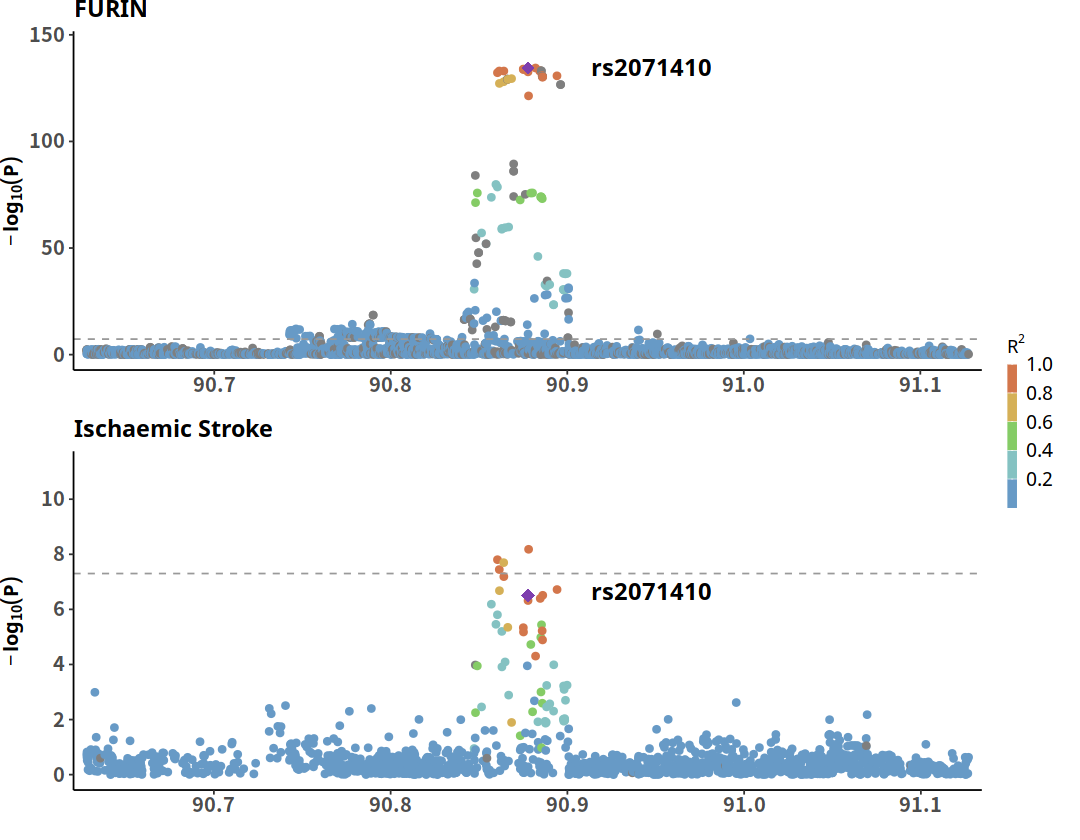

In [24]:
# Arranges the two plots vertically
p_combined <- plot_grid(plot1 + theme(legend.position = "none"),
                        plot2 + theme(legend.position = "none"),
                        ncol = 1,                        
                        label_x = c(0,0),label_y = 1,
                        align = 'hv',
                        hjust = 0,
                        rel_heights = c(5,5))

# Adding a Shared Legend
legend <- get_legend(plot1)
p_combined <- plot_grid(p_combined, legend, rel_widths=c(1, 0.1))
print(p_combined)

<span style="font-size:20px; color:black">
This script uses the plotgardener package to create a multi-layered figure that combines p_combined object with a detailed gene track, and then saves the final image as a PDF.
</span>

In [25]:
pdf('./FURIN_IS_locuszoom_with_gene_track.pdf', height=12, width = 12)
pageCreate(width = 12, height = 12,  showGuides = F)

plotGG(plot=p_combined,x=0.1,y=0.1,width = 11,height = 10)

params_gene <- pgParams(chrom = paste0("chr",15),
                        chromstart = 90627783,
                        chromend = 91127339,
                        assembly = "hg38", 
                        x = 0,
                        y=0, 
                        width = 9.2, 
                        default.units = "inches")

genesPlot <- plotGenes(params = params_gene,
                       fontsize = 14,
                       strandLabels = T,
                       fontcolor = c("black", "black"), 
                       fill = c("#669fd9", "#abcc8e"),
                       geneHighlights = data.frame("gene" = "FURIN","color" = "red"),
                       geneBackground = "grey",x = 0.8, y = 10, height = 1, width = 9.2,just = c("left", "top"), default.units = "inches")

annoGenomeLabel(plot = genesPlot,params = params_gene, scale = "Mb",fontsize = 14,x=0.8,y=11,just = c("left", "top"))
dev.off()

gg[gg1]

genes[genes1]

Warning message:
“Start label is rounded.”
Warning message:
“End label is rounded.”
genomeLabel[genomeLabel1]



png 
  2

# Exercise C. Individual-level Proteomics MR in UK Biobank 
<span style="font-size:20px; color:black">
    
**Individual-Level Two-Stage Least Squares Mendelian Randomization (TSLS MR)**
<br>
In the first stage, the exposure variable $X$ is regressed on a set of genetic instruments $Z$, producing predicted values $\hat{X}$ that represent the variation in the exposure explained by genetic variation: 
$$X_i = \pi_0 + \boldsymbol{\pi}_1^\top Z_i + \epsilon_{1i}$$
<br>
In the second stage, the outcome $Y$ is regressed on the predicted exposure values $\hat{X_i}$ obtained from stage one:
$$Y_i = \beta_0 + \beta_1 \hat{X}_i + \epsilon_{2i}$$
<br>
Here, $\beta_1$ provides an estimate of the causal effect of $X$ on $Y$
</span>

## Part 1. Cohort Definition
<span style="font-size:20px; color:black">

**Ischemic Stroke Cohort Definition:**
Participants from the UK Biobank (UKB) were included after applying the following exclusion criteria:
1. Approximately 50,000 individuals from the UKB-PPP project were excluded to avoid sample overlap;
2. Non-European ancestry;
3. History of stroke prior to baseline;
4. Transient ischemic attack (TIA);
5. Sex mismatch between self-reported and genetically inferred sex.<br>

**Outcome Definition:**
Incident ischemic stroke occurring within 15 years following baseline assessment.<br>

**Exposure:** cis-pQTLs genotype for FURIN, MMP12, KIAA0319, PROCR and GRK5 <br>
**Model:** Logistics model <br>

</span>

<span style="font-size:20px; color:black">

- Due to the large sample size (~350,000 individuals), the computational burden of performing individual-level TSLS MR for all proteins was prohibitively high. Therefore, we selecting the top ten proteins with the most significant effect on outcome for further investigation.

- Protein (e.g., FABP3) refers to the protein genetic score, estimated using cis-pQTLs in the first-stage equation, with SNP weights obtained from the UKB-PPP dataset.

</span>

In [ ]:
# The file is too large to run 

# First stage: calculating each protein genetic score
#plink2 --bfile ukb_imp_ALL_22_chr_trans \
#        --score-list weights_list 1 2 6 header cols=scoresums \ # 1 represents column number of SNP,2 represents effect allele,3 represents weights
#        --out Olink_cis_score \


In [26]:
# load Ischaemic Stroke data from UKB cohort
data_cohort <- readRDS("/home/student/Proteomics_MR/Data/UKB_IS/data_ukb_IS.rds")
str(data_cohort)


'data.frame':	350822 obs. of  29 variables:
 $ AGE           : num  56.7 64.7 45.4 46.9 56.1 ...
 $ SEX           : int  1 0 0 0 0 0 1 1 0 1 ...
 $ SMK_Status    : int  0 0 1 0 0 0 0 0 0 0 ...
 $ ALC_Status    : int  1 1 1 1 1 1 0 0 1 1 ...
 $ SBP           : int  115 131 135 171 126 141 140 114 147 133 ...
 $ DBP           : int  78 70 80 106 56 92 80 76 87 79 ...
 $ BMI           : num  25.8 20.7 24.9 30.9 28.8 ...
 $ outcome_15y   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ outcome_15y_dd: num  5479 5479 5479 5479 5479 ...
 $ PC1           : num  -0.009225 0.000484 0.000322 0.000323 0.000437 ...
 $ PC2           : num  5.50e-03 7.09e-05 -2.27e-04 3.62e-05 -2.37e-05 ...
 $ PC3           : num  -0.001178 -0.000648 -0.001013 -0.00074 -0.000788 ...
 $ PC4           : num  -0.000649 -0.001121 0.000968 0.000754 -0.000265 ...
 $ PC5           : num  0.000249 -0.001589 0.003383 0.002724 0.001353 ...
 $ PC6           : num  -0.00078 -0.000621 -0.001128 -0.001253 -0.001422 ...
 $ PC7           : num  0

## Part 2. Conducting second stage regression by logistics model
**Multiple testing and Calculation of effective number of independent Proteins**
<span style="font-size:20px; color:black">
    
Because many proteins were correlated, we use eigendecomposition method to estimate the effective number of independent proteins:<br> The estimated effective number of independent proteins was 24, and it will be used to adjust the P value for multiple testing of Proteomis MR, using a Bonferroni correction (0.05/24 = 0.00208), to detect independent protein-stroke causal effect.

**Citation:**: Chen, Y. et al. Genomic atlas of the plasma metabolome prioritizes metabolites implicated in human diseases. Nat Genet 55, 44–53 (2023).
</span>

In [27]:
# a bit slow
top_protein_list <- c("FABP3","SIL1","GRK5","CRIM1","MMUT","AOC1","GP5","FGF5","MTSS2","BPIFB2")

fits_logistics <- lapply(top_protein_list, function(pro){
    formula <- as.formula(paste0("outcome_15y ~ AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + " , pro))
    fit <- glm(formula, family = binomial(link='logit'), data = data_cohort)
    return(fit)
})

res_logistics <- lapply(fits_logistics, Logistics_format) %>% do.call(what = rbind, .) %>% data.frame()
res_logistics$Bonferroni_sig <- ifelse(res_logistics$p_tsls < 0.05/24, "sig", "non-sig")

print(res_logistics)

   Assay_Target b_tsls se_tsls wald.test   p_tsls Bonferroni_sig
1         FABP3  -0.73     0.2     -3.64 0.000269            sig
2          SIL1   1.08    0.29      3.71 0.000205            sig
3          GRK5 -0.214  0.0625     -3.43 0.000613            sig
4         CRIM1 -0.483   0.137     -3.52 0.000433            sig
5          MMUT  -0.58   0.171     -3.38 0.000713            sig
6          AOC1 -0.219  0.0649     -3.38 0.000731            sig
7           GP5  0.458   0.152      3.01  0.00258        non-sig
8          FGF5 0.0837  0.0268      3.13  0.00176            sig
9         MTSS2  0.975   0.308      3.17  0.00155            sig
10       BPIFB2 -0.195   0.065        -3  0.00272        non-sig


## Part 3. Adding independent predictors
<span style="font-size:20px; color:black">

- Compared to summary-level analyses, the availability of individual-level data allows for improved statistical power in testing proteins of interest by adjusting for independent predictors of ischaemic stroke.<br>

- For example, the following analysis additionally included **smoking** and **alcohol consumption** as covariates in the model.
    
</span>

<span style="font-size:20px; color:black">

Correlation Heatmap indicates that **No multicollinearity** exists between the smoking and alcohol status and the protein genetic score.
</span>

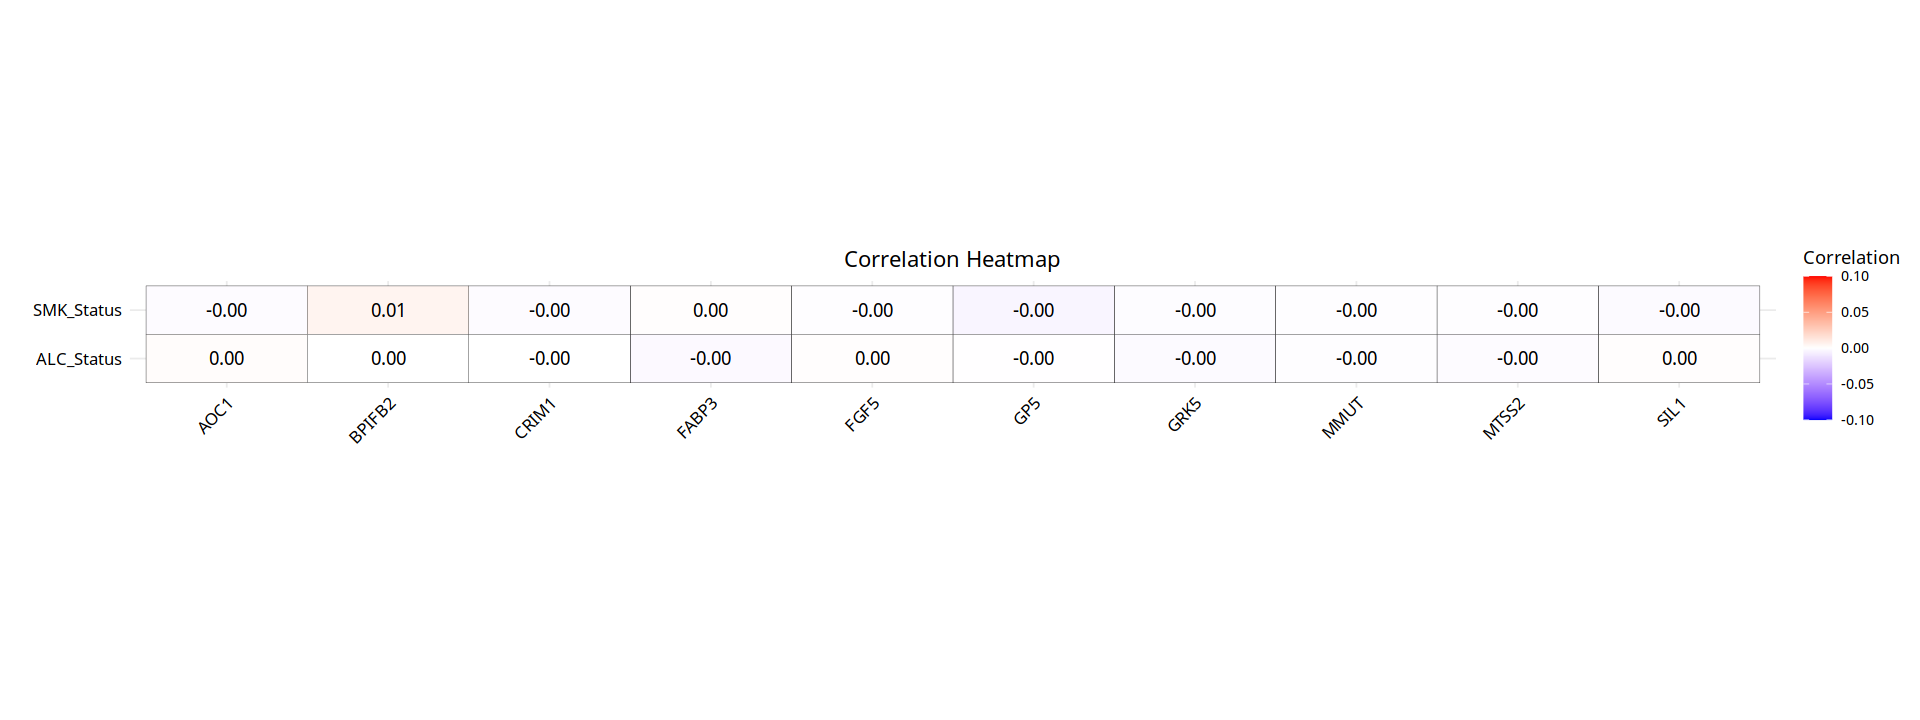

In [28]:
# Calculating correlation matrix
vars1 <- c("SMK_Status", "ALC_Status")
vars2 <- c("FABP3","SIL1","GRK5","CRIM1","MMUT","AOC1","GP5","FGF5","MTSS2","BPIFB2")

cors <- sapply(vars1, function(a) {
    sapply(vars2, function(b) cor(data_cohort[[a]], data_cohort[[b]], use="complete.obs"))
})

options(repr.plot.width = 16, repr.plot.height = 6)
plot_Heatmap(cors = cors, vars1, vars2)

<span style="font-size:20px; color:black">
Proteins GP5 and BPIFB2 are newly identified as significant:

</span>

In [29]:
# slow
top_protein_list <- c("FABP3","SIL1","GRK5","CRIM1","MMUT","AOC1","GP5","FGF5","MTSS2","BPIFB2")

fits_logistics_v2 <- lapply(top_protein_list, function(pro){
    formula <- as.formula(paste0("outcome_15y ~ AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + SMK_Status + ALC_Status + " , pro))
    fit <- glm(formula, family = binomial(link='logit'), data = data_cohort)
    return(fit)
})

res_logistics_v2 <- lapply(fits_logistics_v2, Logistics_format) %>% do.call(what = rbind, .) %>% data.frame()
res_logistics_v2$Bonferroni_sig <- ifelse(res_logistics_v2$p_tsls < 0.05/24, "sig", "non-sig")

print(res_logistics_v2)

   Assay_Target b_tsls se_tsls wald.test   p_tsls Bonferroni_sig
1         FABP3 -0.739   0.201     -3.67 0.000241            sig
2          SIL1   1.06   0.291      3.64 0.000276            sig
3          GRK5 -0.218  0.0628     -3.47 0.000525            sig
4         CRIM1 -0.476   0.138     -3.46 0.000548            sig
5          MMUT -0.594   0.172     -3.46  0.00055            sig
6          AOC1 -0.221  0.0652     -3.38 0.000721            sig
7           GP5  0.487   0.153      3.19  0.00142            sig
8          FGF5 0.0846  0.0269      3.15  0.00163            sig
9         MTSS2  0.956   0.308       3.1  0.00192            sig
10       BPIFB2 -0.202  0.0652     -3.09  0.00201            sig


## Conduct sensitivity analysis using the colocalization

In [30]:
# --- Colocalization Analysis for BPIFB2 and Ischaemic Stroke ---
# load summary data for Proteins
BPIFB2_coloc <- fread("/home/student/Proteomics_MR/Data/Exposure/coloc/UKB_PROTEIN_CIS_region_BPIFB2.txt", nThread = 4) %>% 
  mutate(across(c(pvalues, N, MAF, beta, varbeta), ~ as.numeric(as.character(.)))) %>% 
  distinct(snp, .keep_all = TRUE)

IS_UKB_coloc <- fread("/home/student/Proteomics_MR/Data/UKB_IS/IS_UKB_chr20_31332444_31832444", nThread = 2) 

# Format for coloc: requires beta, varbeta (se^2), and sample size (N).
D1 <- list(
  pvalues = BPIFB2_coloc$pvalues,
  MAF = BPIFB2_coloc$MAF,
  beta = BPIFB2_coloc$beta,
  varbeta = BPIFB2_coloc$varbeta,
  snp = BPIFB2_coloc$snp,
  N = BPIFB2_coloc$N,
  type = "quant" # "quant" for quantitative trait
)

# --- 2. Prepare Outcome Data for Coloc ---
D2 <- list(
  beta = IS_UKB_coloc$BETA,
  varbeta = IS_UKB_coloc$SE^2,
  pvalues = IS_UKB_coloc$P,
  snp = IS_UKB_coloc$ID,
  N = IS_UKB_coloc$samplesize.outcome,
  s = (7362 / 350822), # Proportion of cases
  type = "cc" # "cc" for case-control
)

# --- 3. Run Colocalization ---
coloc_results <- suppressWarnings(coloc.abf(dataset1 = D1, dataset2 = D2))

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
2.17e-265  4.50e-01 1.00e-266  2.04e-02  5.30e-01 
[1] "PP abf for shared variant: 53%"


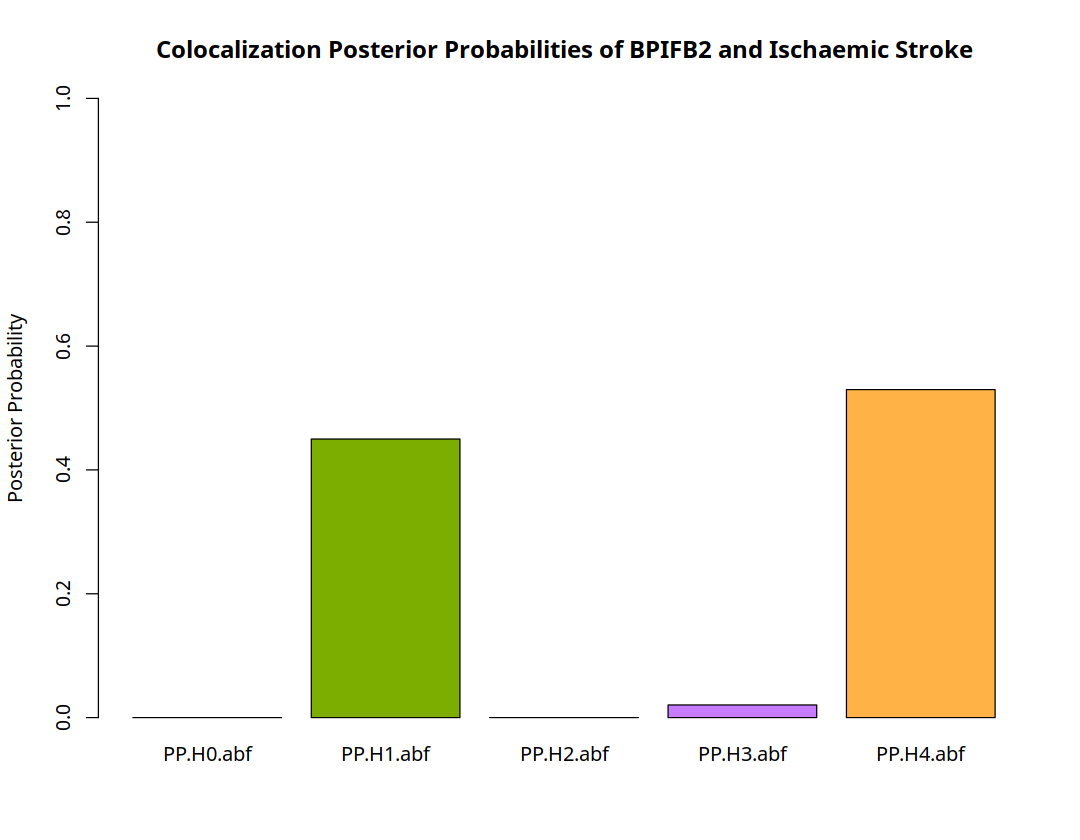

In [31]:
plot_pph <- coloc_results$summary[c("PP.H0.abf", "PP.H1.abf", "PP.H2.abf", "PP.H3.abf", "PP.H4.abf")]
options(repr.plot.width = 9, repr.plot.height = 7)
barplot(plot_pph,
        names.arg = names(plot_pph),
        col = c("#F8766D", "#7CAE00", "#00BFC4", "#C77CFF", "#FFB347"),
        ylab = "Posterior Probability",ylim = c(0,1),
        main = "Colocalization Posterior Probabilities of BPIFB2 and Ischaemic Stroke")

Warning message:
“Removed 937 rows containing missing values or values outside the scale range
(`geom_hline()`).”


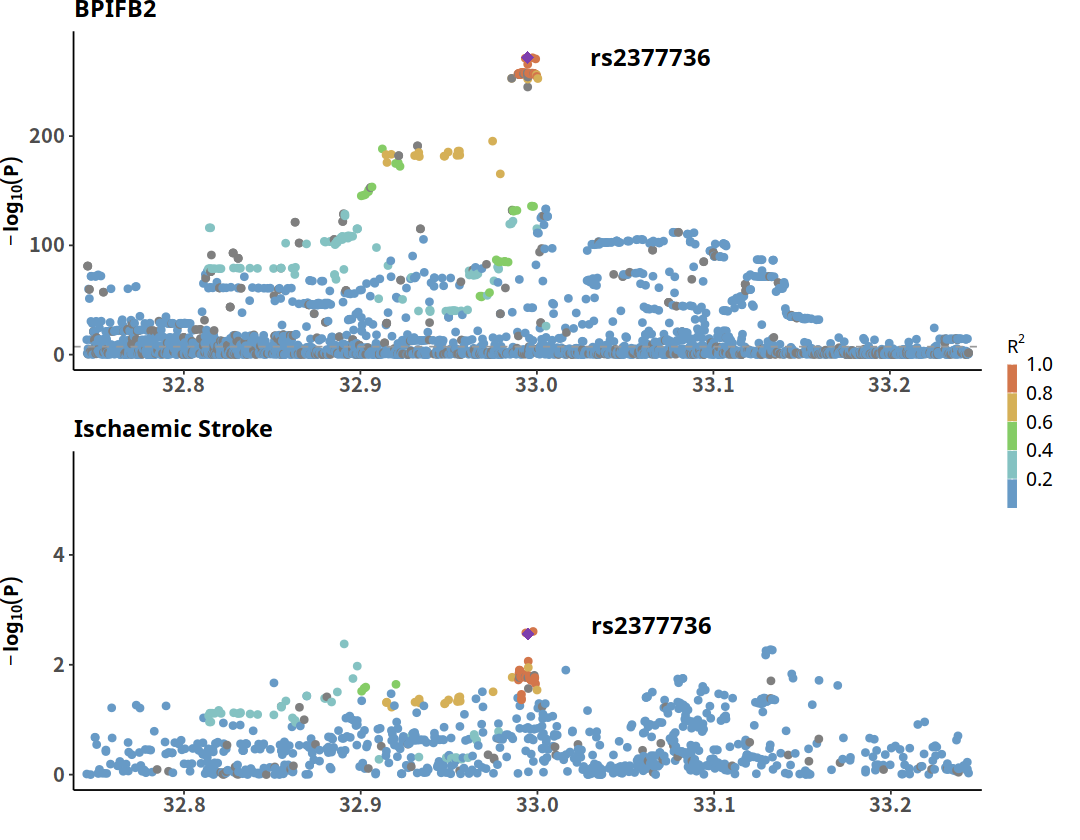

In [32]:
plot3 <- plot_locuszoom(file_path = "/home/student/Proteomics_MR/Data/Exposure/coloc/BPIFB2/chr20_32744638-33244638.Rdata", refSNP = "rs2377736", refSNP_POS = "32994638", pheno = "BPIFB2")
plot4 <- plot_locuszoom(file_path = "/home/student/Proteomics_MR/Data/UKB_IS/UKB_IS_hg38_BPIFB2_rs2377736_250725/chr20_32744638-33244638.Rdata", refSNP = "rs2377736", refSNP_POS = "32994638", pheno = "Ischaemic Stroke")
# Arranges the two plots vertically
p_combined <- plot_grid(plot3 + theme(legend.position = "none"),
                        plot4 + theme(legend.position = "none"),
                        ncol = 1,                        
                        label_x = c(0,0),label_y = 1,
                        align = 'hv',
                        hjust = 0,
                        rel_heights = c(5,5))

# Adding a Shared Legend
legend <- get_legend(plot3)
p_combined <- plot_grid(p_combined, legend, rel_widths=c(1, 0.1))
print(p_combined)

## Part 4. Summary data analysis in the same data cohort
<span style="font-size:20px; color:black">
    
The results of the summary data analysis were almost identical to those from the TSLS model that was adjusted only for age, sex, and PCs 1–10.

</span>

In [33]:
# Load GWAS summary statistics for the Ischemic Stroke from the UK Biobank cohort.
outcome_ukb <- read.table("/home/student/Proteomics_MR/Data/UKB_IS/UKB_IS_cispQTLs_GWAS", sep = "\t", header = T)
str(outcome_ukb)

outcome_ukb_format <- format_data(dat = outcome_ukb,
                                  type = "outcome",
                                  phenotype_col = "pheno",
                                  header = T,
                                  snp_col = "ID",
                                  beta_col = "BETA",
                                  se_col = "SE",
                                  effect_allele_col = "ALT",
                                  other_allele_col = "REF",
                                  pval_col = "P",
                                  eaf_col = "A1_FREQ",
                                  ncase_col = "n_cases",
                                  ncontrol_col = "n_controls")

'data.frame':	1618 obs. of  18 variables:
 $ CHROM    : int  4 4 5 5 22 1 7 9 10 1 ...
 $ POS      : int  7434607 110659067 75930640 42689540 41291730 113061959 55236796 117695685 131445731 1680219 ...
 $ ID       : chr  "rs10014338" "rs10033900" "rs10037254" "rs10038285" ...
 $ REF      : chr  "A" "C" "A" "A" ...
 $ ALT      : chr  "C" "T" "G" "G" ...
 $ A1       : chr  "C" "T" "G" "G" ...
 $ A1_FREQ  : num  0.815 0.481 0.396 0.263 0.468 ...
 $ FIRTH.   : chr  "N" "N" "N" "N" ...
 $ TEST     : chr  "ADD" "ADD" "ADD" "ADD" ...
 $ OBS_CT   : int  348379 350822 350795 349385 349080 346333 339590 346942 347989 341978 ...
 $ BETA     : num  -0.000385 0.033441 0.003687 0.00689 -0.004915 ...
 $ SE       : num  0.0216 0.0168 0.0171 0.019 0.0168 ...
 $ Z_STAT   : num  -0.0178 1.995 0.2151 0.362 -0.2917 ...
 $ P        : num  0.986 0.046 0.83 0.717 0.77 ...
 $ ERRCODE  : chr  "." "." "." "." ...
 $ pheno    : chr  "Ischaemic STROKE" "Ischaemic STROKE" "Ischaemic STROKE" "Ischaemic STROKE" ...
 

In [34]:
# Same analysis workflow as used for the GIGASTROKE outcome above.
dat_ukb <- suppressMessages(harmonise_data(exposure_dat = exposure_cis_format, outcome_dat = outcome_ukb_format))
res_ukb <- suppressMessages(mr(dat_ukb))

res_ukb$Bonferroni_sig <- ifelse(res_ukb$pval < 0.05/24, "sig", "non-sig")
print(res_ukb[res_ukb$Bonferroni_sig == "sig",])

     id.exposure id.outcome          outcome exposure     method nsnp
27        0NlTgn     rffuSB Ischaemic STROKE    FABP3 Wald ratio    1
42        1dfZ6r     rffuSB Ischaemic STROKE     SIL1 Wald ratio    1
352       brbNA3     rffuSB Ischaemic STROKE     AOC1 Wald ratio    1
474       e9gFPQ     rffuSB Ischaemic STROKE    CRIM1 Wald ratio    1
535       fFbrfv     rffuSB Ischaemic STROKE     MMUT Wald ratio    1
751       jiLqhS     rffuSB Ischaemic STROKE     GRK5 Wald ratio    1
1079      PUQr3f     rffuSB Ischaemic STROKE     FGF5 Wald ratio    1
1220      SJxCAl     rffuSB Ischaemic STROKE    MTSS2 Wald ratio    1
               b         se         pval Bonferroni_sig
27   -0.72894792 0.20031302 0.0002736519            sig
42    1.07687797 0.28968814 0.0002013076            sig
352  -0.21921010 0.06493515 0.0007359309            sig
474  -0.48308301 0.13722680 0.0004310174            sig
535  -0.58166602 0.17135825 0.0006876806            sig
751  -0.21315872 0.06242310 0.0006

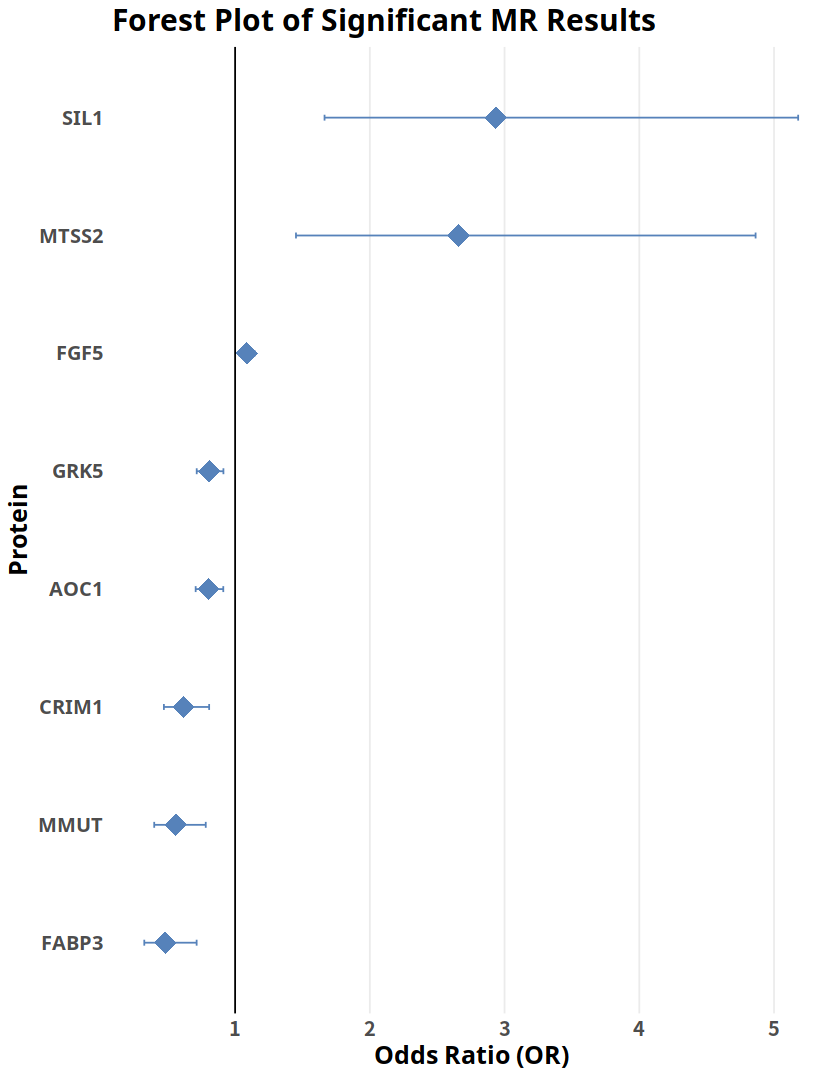

In [35]:
# Visualizing Results with a Forest Plot

options(repr.plot.width = 7, repr.plot.height = 9)
p_forest_ukb <- forest_plot(res_ukb)
p_forest_ukb